# Домашнее задание 6
## EM-алгоритм для рассекречивания данных

Сбербанк начал крупный совместный AI-проект с Европейской комиссией. В рамках проекта специалисты Сбербанка будут разрабатывать мощную систему искусственного интелеллекта для автоматизации работы институтов Евросоюза, а Евросоюз - поставлять данные и экспертизу в прикладной области. Чтобы обеспечить максимальную безопасность при передаче наиболее ценной и особо секретной информации, Еврокомиссия тайно пригласила в Брюссель надежного человека из России и передала данные на внешнем носителе. В целях безопасности имя этого человека не сообщается. Чтобы Сбербанк мог назначить встречу со специалистом, Еврокомиссия прислала его зашумленные фото и сообщила, что это член группы [байесовских методов машинного обучения](http://bayesgroup.ru/people). Помогите Сбербанку восстановить фотографию специалиста!

Когда вы узнаете, [кто это](http://bayesgroup.ru/people), пришлите:
* имя и фамилию этого человека
* восстановленное фото человека
* этот ноутбук с вашим решением

Надежде Чирковой (@nadiinchi в Телеграме). Первые два человека получат небольшой подарок в благодарность за помощь Сбербанку! Пожалуйста, не делайте спойлеров другим студентам!

У вас есть __только одна попытка__ отправить сообщение!

Обратите внимание, что отправка сообщения не означает сдачу задания. Чтобы сдать задание, загрузите аккуратно оформленный ipynb файл в Anytask (это можно сделать позже, но до дедлайна).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
DATA_FILE = "data_hw6.npy"
w = 75 # face_width

### Данные

Вам выдан набор $K$ зашумленных изображений размера $H \times W$.

Он представлен в виде numpy-матрицы размера $H \times W \times K$:

In [3]:
X = np.load(DATA_FILE)

In [4]:
X.shape # H, W, K

(100, 200, 1000)

Пример зашумленного изображения:

(-0.5, 199.5, 99.5, -0.5)

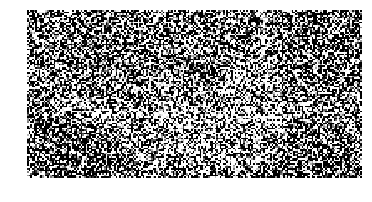

In [5]:
plt.imshow(X[:, :, 0], cmap="Greys_r")
plt.axis("off")

### Цель и план

Наша цель - восстановить лицо $F$ ($H \times w$).

Также мы найдем:
* $B$: фон изображения  ($H \times W$)
* $s$: стандартное отклонение шума (float)
* $a$: дискретное априорное распределение на позицию лица на изображении ($W-w+1$)
* $q(d)$: дискретное апостериорное распределение на позицию лица на каждом изображении (($W-w+1$) x $K$)

План реализации:
1. вычисление $log\, p(X  \mid d,\,F,\,B,\,s)$
1. вычисление $\mathcal{L}$
1. E-шаг: поиск $q(d)$
1. M-шаг: оценка $F,\, B, \,s, \,a$
1. составление EM-алгоритма из E- и M-шагов.

### Реализация

In [ ]:
### Variables to test implementation
### Just run this cell
tH, tW, tw, tK = 2, 3, 1, 2
tX = np.arange(tH*tW*tK).reshape(tH, tW, tK)
tF = np.arange(tH*tw).reshape(tH, tw)
tB = np.arange(tH*tW).reshape(tH, tW)
ts = 0.1
ta = np.arange(1, (tW-tw+1)+1)
ta = ta / ta.sum()
tq = np.arange(1, (tW-tw+1)*tK+1).reshape(tW-tw+1, tK)
tq = tq / tq.sum(axis=0)[np.newaxis, :]

#### 1. Реализуйте функцию calculate_log_probability
Для $k$-го изображения $X_k$ и некоторой позиции лица $d_k$:
$$p(X_k  \mid d_k,\,F,\,B,\,s) = \prod_{ij}
    \begin{cases} 
    	\mathcal{N}(X_k[i,j]\mid F[i,\,j-d_k],\,s^2), 
    	& \text{if}\, (i,j)\in faceArea(d_k)\\
    	\mathcal{N}(X_k[i,j]\mid B[i,j],\,s^2), & \text{else}
    \end{cases}$$

Важные указания:
* Не забудьте про логарифм!
* В реализации этой функции должно быть не больше 1 цикла! (цикл по d_k)

In [ ]:
def calculate_log_probability(X, F, B, s):
    """
    Calculates log p(X_k|d_k, F, B, s) for all images X_k in X and
    all possible face position d_k.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    F : array, shape (H, w)
        Estimate of prankster's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.

    Returns
    -------
    ll : array, shape(W-w+1, K)
        ll[dw, k] - log-likelihood of observing image X_k given
        that the prankster's face F is located at position dw
    """
    # your code here

In [ ]:
# run this cell to test your implementation
expected = np.array([[-3541.69812064, -5541.69812064],
       [-4541.69812064, -6741.69812064],
       [-6141.69812064, -8541.69812064]])
actual = calculate_log_probability(tX, tF, tB, ts)
assert np.allclose(actual, expected)
print("OK")

#### 2. Реализуйте функцию calculate_lower_bound
$$\mathcal{L}(q, \,F, \,B,\, s,\, a) = \sum_k \biggl (\mathbb{E} _ {q( d_k)}\bigl ( \log p(  X_{k}  \mid {d}_{k} , \,F,\,B,\,s) + 
    \log p( d_k  \mid a)\bigr) - \mathbb{E} _ {q( d_k)} \log q( d_k)\biggr) $$
    
Важные указания:
* Используйте уже реализованную функцию calculate_log_probability! 
* Учтите, что распределения $q( d_k)$ and $p( d_k  \mid a)$ - дискретные. Например, $P(d_k=i \mid a) = a[i]$.
* В реализации этой функции не должно быть циклов!

In [ ]:
def calculate_lower_bound(X, F, B, s, a, q):
    """
    Calculates the lower bound L(q, F, B, s, a) for 
    the marginal log likelihood.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    F : array, shape (H, w)
        Estimate of prankster's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.
    a : array, shape (W-w+1)
        Estimate of prior on position of face in any image.
    q : array
        q[dw, k] - estimate of posterior 
                   of position dw
                   of prankster's face given image Xk

    Returns
    -------
    L : float
        The lower bound L(q, F, B, s, a) 
        for the marginal log likelihood.
    """
    # your code here

In [ ]:
# run this cell to test your implementation
expected = -12761.1875
actual = calculate_lower_bound(tX, tF, tB, ts, ta, tq)
assert np.allclose(actual, expected)
print("OK")

#### 3. Реализуйте E-шаг
$$q(d_k) = p(d_k \mid X_k, \,F, \,B, \,s,\, a) = 
\frac {p(  X_{k}  \mid {d}_{k} , \,F,\,B,\,s)\, p(d_k \mid a)}
{\sum_{d'_k} p(  X_{k}  \mid d'_k , \,F,\,B,\,s) \,p(d'_k \mid a)}$$

Важные указания:
* Используйте уже реализованную функцию calculate_log_probability!
* Для вычислительной стабильности выполняйте все вычисления с логарифмами величин и примените к ним экспоненту только перед return. Также используйте следующий трюк:
$$\beta_i = \log{p_i(\dots)} \quad\rightarrow \quad
	\frac{e^{\beta_i}}{\sum_k e^{\beta_k}} = 
	\frac{e^{(\beta_i - \max_j \beta_j)}}{\sum_k e^{(\beta_k- \max_j \beta_j)}}$$
* В реализации этой функции не должно быть циклов!

In [ ]:
def run_e_step(X, F, B, s, a):
    """
    Given the current esitmate of the parameters, for each image Xk
    esitmates the probability p(d_k|X_k, F, B, s, a).

    Parameters
    ----------
    X : array, shape(H, W, K)
        K images of size H x W.
    F  : array_like, shape(H, w)
        Estimate of prankster's face.
    B : array shape(H, W)
        Estimate of background.
    s : float
        Eestimate of standard deviation of Gaussian noise.
    a : array, shape(W-w+1)
        Estimate of prior on face position in any image.

    Returns
    -------
    q : array
        shape (W-w+1, K)
        q[dw, k] - estimate of posterior of position dw
        of prankster's face given image Xk
    """
    # your code here

In [ ]:
# run this cell to test your implementation
expected = np.array([[ 1.,  1.],
                   [ 0.,  0.],
                   [ 0.,  0.]])
actual = run_e_step(tX, tF, tB, ts, ta)
assert np.allclose(actual, expected)
print("OK")

#### 4. Реализуйте M-шаг
$$a[j] = \frac{\sum_k q( d_k = j )}{\sum_{j'}  \sum_{k'} q( d_{k'} = j')}$$
$$F[i, m] = \frac 1 K  \sum_k \sum_{d_k} q(d_k)\, X^k[i,\, m+d_k]$$
$$B[i, j] = \frac {\sum_k \sum_{ d_k:\, (i, \,j) \,\not\in faceArea(d_k)} q(d_k)\, X^k[i, j]} 
	  	{\sum_k \sum_{d_k: \,(i, \,j)\, \not\in faceArea(d_k)} q(d_k)}$$
$$s^2 = \frac 1 {HWK}   \sum_k \sum_{d_k} q(d_k)
	  	\sum_{i,\, j}  (X^k[i, \,j] - Model^{d_k}[i, \,j])^2$$

где $Model^{d_k}[i, j]$ - это изображение, составленное из фона и лица, размещенного в положении $d_k$.

Важные указания:
* Обновляйте параметры в следующем порядке: $a$, $F$, $B$, $s$.
* Когда параметр обновлен, его __новое__ значение используется для обновления других параметров.
* В реализации этой функции должно быть не более 3 циклов (а лучше только 2) и не должно быть вложенных циклов!

In [ ]:
def run_m_step(X, q, w):
    """
    Estimates F, B, s, a given esitmate of posteriors defined by q.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    q  :
        q[dw, k] - estimate of posterior of position dw
                   of prankster's face given image Xk
    w : int
        Face mask width.

    Returns
    -------
    F : array, shape (H, w)
        Estimate of prankster's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.
    a : array, shape (W-w+1)
        Estimate of prior on position of face in any image.
    """
    # your code here

In [ ]:
# run this cell to test your implementation
expected = [np.array([[ 3.27777778],
                      [ 9.27777778]]),
 np.array([[  0.48387097,   2.5       ,   4.52941176],
           [  6.48387097,   8.5       ,  10.52941176]]),
  0.94868,
 np.array([ 0.13888889,  0.33333333,  0.52777778])]
actual = run_m_step(tX, tq, tw)
for a, e in zip(actual, expected):
    assert np.allclose(a, e)
print("OK")

#### 5. Реализуйте EM_algorithm
Инициализируйте параметры, если они не переданы, и повторяйте E- и M-шаги до сходимости. Сходимость наступает, когда разница между значениями $\mathcal{L}(q, \,F, \,B, \,s, \,a)$ на данной и предыдущей итерации меньше величины tolerance.

Значение $\mathcal{L}(q, \,F, \,B, \,s, \,a)$ должно возрастать после каждого обновления.

In [ ]:
def run_EM(X, w, F=None, B=None, s=None, a=None, tolerance=0.001,
           max_iter=50):
    """
    Runs EM loop until the likelihood of observing X given current
    estimate of parameters is idempotent as defined by a fixed
    tolerance.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    w : int
        Face mask width.
    F : array, shape (H, w), optional
        Initial estimate of prankster's face.
    B : array, shape (H, W), optional
        Initial estimate of background.
    s : float, optional
        Initial estimate of standard deviation of Gaussian noise.
    a : array, shape (W-w+1), optional
        Initial estimate of prior on position of face in any image.
    tolerance : float, optional
        Parameter for stopping criterion.
    max_iter  : int, optional
        Maximum number of iterations.

    Returns
    -------
    F, B, s, a : trained parameters.
    LL : array, shape(number_of_iters + 2,)
        L(q, F, B, s, a) at initial guess, 
        after each EM iteration and after
        final estimate of posteriors;
        number_of_iters is actual number of iterations that was done.
    """
    H, W, N = X.shape
    if F is None:
        F = np.random.randint(0, 255, (H, w))
    if B is None:
        B = np.random.randint(0, 255, (H, W))
    if a is None:
        a = np.ones(W - w + 1)
        a /= np.sum(a)
    if s is None:
        s = np.random.rand()*pow(64,2)
    # your code here
    

In [ ]:
# run this cell to test your implementation
res = run_EM(tX, tw, max_iter=3)
LL = res[-1]
assert np.alltrue(LL[1:] - LL[:-1] > 0)
print("OK")

### Кого отправил Брюссель?

Чтобы ускорить вычисления, мы выполним 5 итераций по маленькому набору изображений и далее будем постепенно увеличивать число изображений.

Если все реализовано верно, вы сможете узнать специалиста, сравнив его фотографию с фотографиями членов группы байесовских методов.

Запустите EM-алгоритм:

In [ ]:
def show(F, i=1, n=1):
    """
    shows face F at subplot i out of n
    """
    plt.subplot(1, n, i)
    plt.imshow(F, cmap="Greys_r")
    plt.axis("off")

In [ ]:
F, B, s, a = [None] * 4
LL = []
lens = [50, 100, 300, 500, 1000]
iters = [5, 1, 1, 1, 1]
plt.figure(figsize=(20, 5))
for i, (l, it) in enumerate(zip(lens, iters)):
    F, B, s, a, _ = run_EM(X[:, :, :l], w, F, B, s, a, max_iter=it)
    show(F, i+1, 5)

Фон:

In [ ]:
show(B)

### Бонусное задание: hard-EM
За выполнение этого задания можно получить 5 бонусных баллов.

В бонусной части предлагается реализовать упрощенный алгоритм hard-EM и сравнить результат его работы с полным агоритмом. В алгоритме hard-EM вместо поиска апостериорного распределения на позицию лица $p(d_k|X_k, F, B, s, A)$ на E-шаге выполняется поиск аргмаксимума этого распределения $\tilde d_k$ для каждого изображения $k$. Таким образом, распределение q заменяется вырожденным распределением:
$$q(d_k) = \begin{cases} 1, \, if d_k = \tilde d_k \\ 0, \, otherwise\end{cases}$$
Эта модификация упрощает формулы для $\mathcal{L}$ и для M-шага и ускоряет их вычисление. Однако, сходится hard-EM медленнее.

Если вы реализуете hard-EM, добавьте бинарный флаг hard_EM в прототипы следующих функций:
* calculate_lower_bound
* run_e_step
* run_m_step
* run_EM

и реализуйте обработку этого флага (использование упрощенного алгоритма вместо полного).

Сравните результат (восстановленное лицо) и скорость сходимости (в терминах числа итераций и в терминах времени работы) EM и hard EM.